In [1]:
# %cd ../..
!git clone https://github.com/Ton3t3/Lab2-RL

%cd Lab2-RL/problem 1

fatal: destination path 'Lab2-RL' already exists and is not an empty directory.
/content/Lab2-RL/problem 1


In [2]:
!pip install swig
!pip install "gymnasium[box2d]"

In [3]:
# Copyright [2025] [KTH Royal Institute of Technology]
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 2 for EL2805 - Reinforcement Learning.


# Load packages
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
from tqdm import trange
import warnings, sys
warnings.simplefilter(action='ignore', category=FutureWarning)
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MyNetwork(nn.Module):
    """Feedforward neural network that approximates the Q-function.

       The network takes the current state as input and outputs Q-values for all possible actions.
       The action corresponding to the highest Q-value is considered the optimal action.
       - The input size corresponds to the state dimension of the environment.
       - The network has one hidden layer with 64 neurons and ReLU activation.
       - The output layer has one neuron per action (Q-values for each action)."""

    def __init__(self, input_size, output_size, neurons_per_layer):
        super().__init__()
        self.input_layer = nn.Linear(input_size, neurons_per_layer)  # First layer: state -> hidden layer
        self.hidden_layer = nn.Linear(neurons_per_layer, neurons_per_layer)  # Second layer: hidden -> hidden layer
        self.output_layer = nn.Linear(neurons_per_layer, output_size)  # Output layer: hidden -> Q-values
        self.activation = nn.ReLU()  # ReLU activation function for hidden layers

    def forward(self, x):
        """Define forward pass"""
        x = self.activation(self.input_layer(x))  # Apply input layer and ReLU
        x = self.activation(self.hidden_layer(x))  # Apply hidden layer and ReLU
        return self.output_layer(x)  # Return Q-values for all actions
##
def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

# Load model
# try:
#     model = torch.load('neural-network-1.pth')
#     print('Network model: {}'.format(model))
# except:
#     print('File neural-network-1.pth not found!')
#     sys.exit(-1)
try:
    model = torch.load('neural-network-1.pth', weights_only=False)
    print('Network model: {}'.format(model))
except Exception as e:
    print(f'File neural-network-1.pth not found or could not be loaded: {e}')
    sys.exit(-1)

# Import and initialize Mountain Car Environment
env = gym.make('LunarLander-v3')
# If you want to render the environment while training run instead:
# env = gym.make('LunarLander-v3', render_mode = "rgb_array")

env.reset()

# Parameters
N_EPISODES = 50            # Number of episodes to run for trainings
CONFIDENCE_PASS = 50

# Reward
episode_reward_list = []  # Used to store episodes reward

# Simulate episodes
print('Checking solution...')
EPISODES = trange(N_EPISODES, desc='Episode: ', leave=True)
for i in EPISODES:
    EPISODES.set_description("Episode {}".format(i))
    # Reset enviroment data
    done, truncated = False, False
    state = env.reset()[0]
    total_episode_reward = 0.
    while not (done or truncated):
        # plt.imshow(env.render())
        # Get next state and reward.  The done variable
        # will be True if you reached the goal position,
        # False otherwise
        q_values = model(torch.tensor(state, device=dev))
        _, action = torch.max(q_values, dim=0)
        next_state, reward, done, truncated, _ = env.step(action.item())

        # Update episode reward
        total_episode_reward += reward

        # Update state for next iteration
        state = next_state

    # Append episode reward
    episode_reward_list.append(total_episode_reward)


# Close environment
env.close()


avg_reward = np.mean(episode_reward_list)
confidence = np.std(episode_reward_list) * 1.96 / np.sqrt(N_EPISODES)


print('Policy achieves an average total reward of {:.1f} +/- {:.1f} with confidence 95%.'.format(
                avg_reward,
                confidence))

if avg_reward - confidence >= CONFIDENCE_PASS:
    print('Your policy passed the test!')
else:
    print("Your policy did not pass the test! The average reward of your policy needs to be greater than {} with 95% confidence".format(CONFIDENCE_PASS))


Network model: MyNetwork(
  (input_layer): Linear(in_features=8, out_features=64, bias=True)
  (hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=4, bias=True)
  (activation): ReLU()
)
Checking solution...


Episode 49: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s]

Policy achieves an average total reward of 118.3 +/- 30.3 with confidence 95%.
Your policy passed the test!


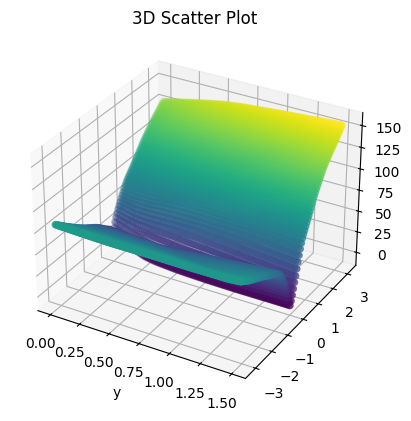

In [4]:
y_array = np.linspace(0,1.5,100)
w_1 = np.linspace(0, np.pi)
w_2 = -w_1[::-1][:-1]
w_array = np.concatenate([w_2, w_1])
input_array = []
q_max_array = []


for y in y_array:
  for w in w_array:
    q_values_limited = model(torch.tensor([0, y, 0, 0, w, 0, 0, 0], device=dev, dtype=torch.float32))
    q_max, _ = torch.max(q_values_limited, dim = 0)
    input_array.append((y,w))
    q_max_array.append(q_max.cpu().item())

fig = plt.figure()
ax = plt.axes(projection='3d')

z = q_max_array
x = [s[0] for s in input_array]
y = [s[1] for s in input_array]

ax.scatter(x, y, z, c=z)
ax.set_title('3D Scatter Plot')
ax.set_xlabel("y")
plt.show()